In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
from PIL import Image
from torchvision import transforms as T
import numpy as np
import requests
from io import BytesIO
import cv2
import random

In [3]:
from model.mask_rcnn import maskrcnn_resnet50_fpn, MaskRCNNPredictor

In [4]:
def get_model(num_classes):
    model = maskrcnn_resnet50_fpn()
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
VOC_CLASSES = [
        "__background__ ",
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "diningtable",
        "dog",
        "horse",
        "motorbike",
        "person",
        "pottedplant",
        "sheep",
        "sofa",
        "train",
        "tvmonitor",
]

In [6]:
model = get_model(len(VOC_CLASSES))
# model = torch.jit.load("../vocseg.zip", map_location="cpu") # Loading with TorchScript

In [7]:
model.load_state_dict(torch.load("voc-seg.pt"))

<All keys matched successfully>

In [8]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

In [21]:
# If loading the model with torchscript, the use this.
# def get_prediction(img_path, model, threshold, url=False):
#     if url:
#         response = requests.get(img_path)
#         img = Image.open(BytesIO(response.content))
#     else:
#         img = Image.open(img_path) # Load the image
#     transform = T.Compose([T.ToTensor()])
#     img = transform(img)
#     pred = model([img])
#     print(pred)
#     pred_score = list(pred[1][0]['scores'].detach().numpy())
#     pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
#     masks = (pred[1][0]['masks']>0.5).squeeze().detach().cpu().numpy()
#     pred_class = [VOC_CLASSES[i] for i in list(pred[1][0]['labels'].numpy())]
#     pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[1][0]['boxes'].detach().numpy())]
#     masks = masks[:pred_t+1]
#     pred_boxes = pred_boxes[:pred_t+1]
#     pred_class = pred_class[:pred_t+1]
#     return masks, pred_boxes, pred_class


In [9]:
def get_prediction(img_path, model, threshold, url=False):
    if url:
        response = requests.get(img_path)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(img_path) # Load the image
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
#     print(pred)
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [VOC_CLASSES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
from urllib.request import urlopen
def url_to_image(url, readFlag=cv2.IMREAD_COLOR):
    resp = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, readFlag)
    return image

In [12]:
def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask


In [13]:
def instance_segmentation(img_path, model, threshold=0.5, rect_th=3, text_size=3, text_th=3, url=False):
    masks, boxes, pred_cls = get_prediction(img_path, model, threshold, url=url)
    if url:
        orimg = url_to_image(img_path)
    else:
        orimg = cv2.imread(img_path) # Read image with cv2
    orimg = cv2.cvtColor(orimg, cv2.COLOR_BGR2RGB)
    img = orimg.copy()
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    # plt.figure(figsize=(20,30))
    # plt.imshow(img)
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()
    return img, pred_cls, masks, orimg, boxes

In [14]:
img, pred_classes, masks, orimg, boxes = instance_segmentation('./airplane.jpg', model, rect_th=2, text_th=1, text_size=0.3)

In [15]:
pred_classes # Items that it found

['aeroplane']

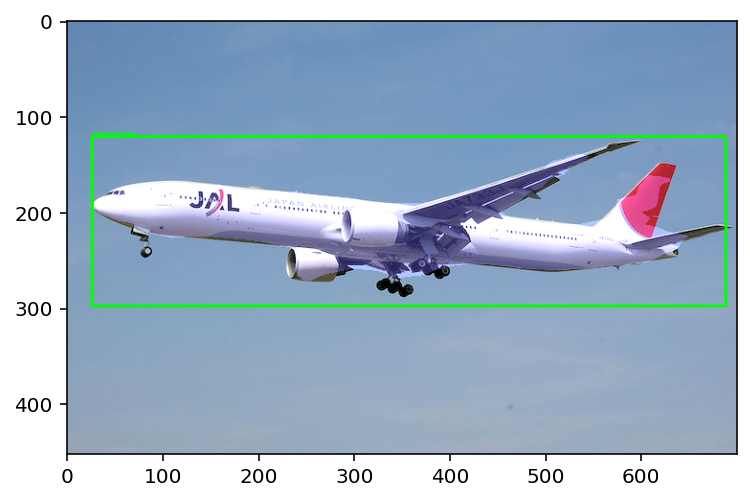

In [16]:
# Items airplane
%matplotlib inline
plt.imshow(img)

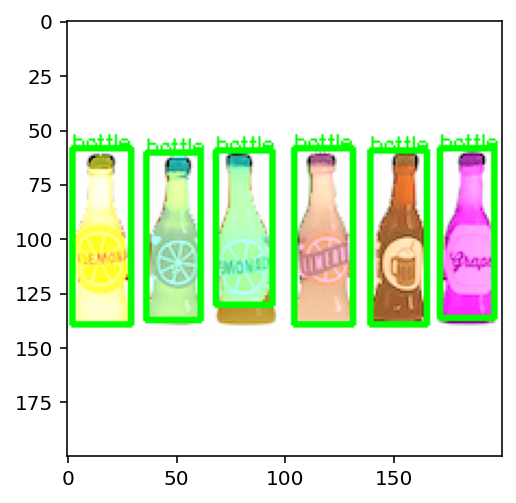

In [103]:
# Items bottles
%matplotlib inline
plt.imshow(img)

In [17]:
def highlight_objects(img, masks, boxes):
    imgr = img.copy()
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        imgr = cv2.addWeighted(imgr, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(imgr, boxes[i][0], boxes[i][1],color=(0, 255, 0))
    return imgr

In [18]:
def get_mask(loc, masks, pred_classes):
    items_found = []
    masks_found = []
    for i, mask in enumerate(masks):
        if mask[loc[1], loc[0]]:
            items_found.append(pred_classes[i])
            masks_found.append(mask)
    return items_found, masks_found

In [19]:
def select_loc(img):
    """
    returns 
    """
    %matplotlib notebook
    fig = plt.figure()
    plt.imshow(img)
    fig.set_label('Choose object or place')
    plt.axis('off')
    target_loc = np.zeros(2, dtype=int)
    def on_mouse_pressed(event):
        target_loc[0] = int(event.xdata)
        target_loc[1] = int(event.ydata)

    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)
    return target_loc

In [20]:
def select_obj(pred_classes, masks, orimg, boxes):
    if len(pred_classes)==1:
        return pred_classes[0], masks[0].astype(np.uint8)
    %matplotlib inline
    fig = plt.figure()
    plt.imshow(highlight_objects(orimg, masks, boxes))
    fig.set_label('Objects found')
    plt.axis('off')
    print(f"Objects in that location:")
    [print("{}) {}".format(i + 1, o)) for i, o in enumerate(pred_classes)]
    while True:
        inp = int(input("Pick a number: "))
        if inp > len(pred_classes):
            print("Too large")
        elif inp < 1:
            print("Can't be less than 1")
        else:
            break
    return pred_classes[inp-1], masks[inp-1]
    

<IPython.core.display.Javascript object>


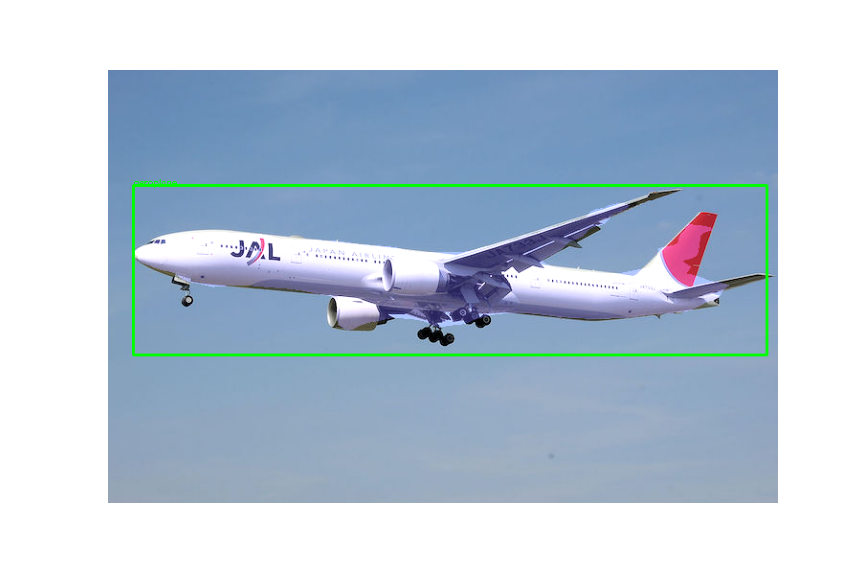

In [22]:
%matplotlib notebook
loc = select_loc(img)

In [23]:
itf, msf = get_mask(loc, masks, pred_classes)

In [24]:
%matplotlib inline
cls, mask = select_obj(itf, msf, orimg, boxes)

Text(0.5, 1.0, 'Selected Object')

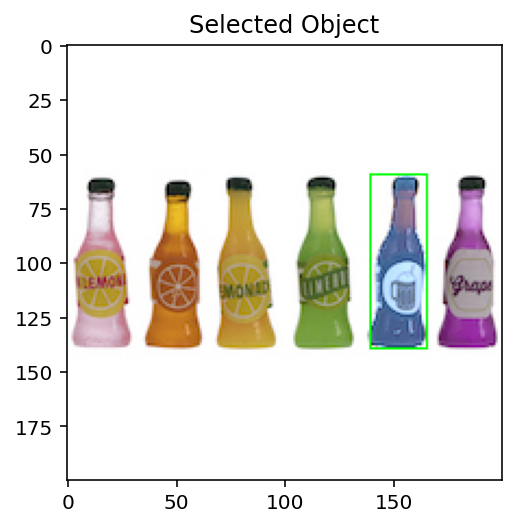

In [108]:
# Selected bottle
plt.imshow(highlight_objects(orimg, msf, boxes))
plt.title("Selected Object")

Text(0.5, 1.0, 'Selected Object')

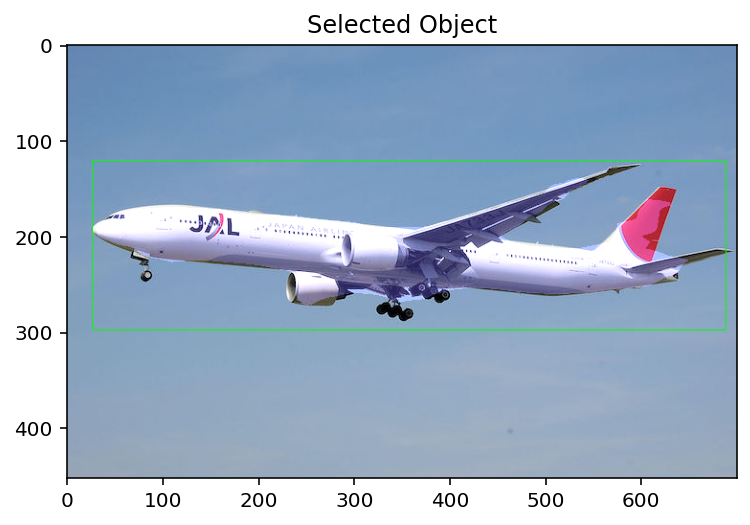

In [25]:
# Airplane selected
plt.imshow(highlight_objects(orimg, msf, boxes))
plt.title("Selected Object")

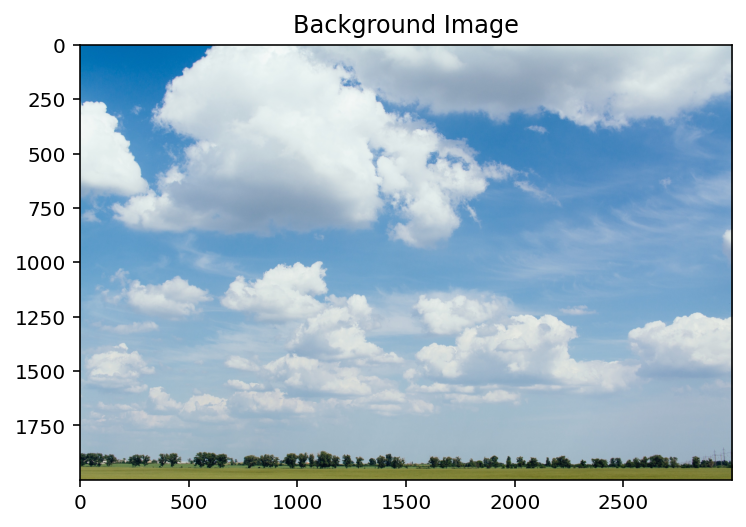

In [26]:
background_img = cv2.cvtColor(cv2.imread('rodion-kutsaev-PEm_sLmJT-w-unsplash.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.title("Background Image")
plt.imshow(background_img)

<IPython.core.display.Javascript object>


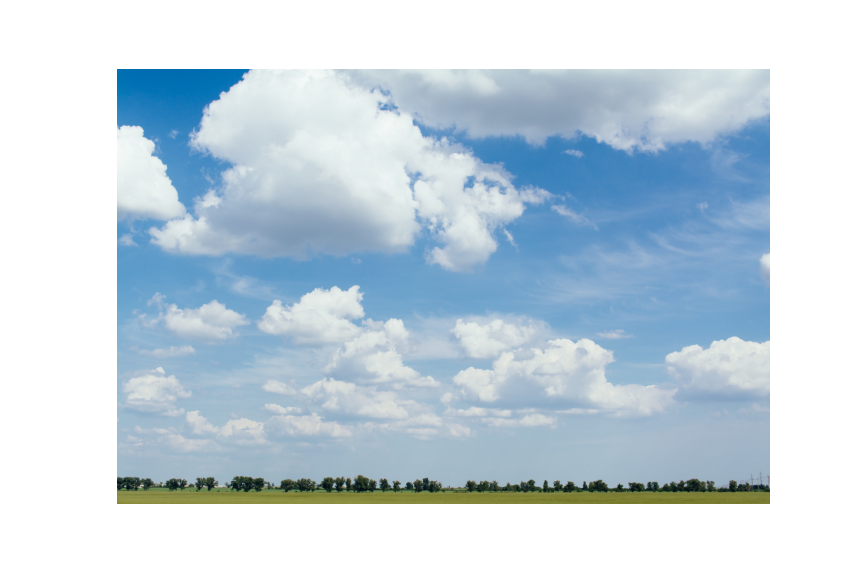

In [27]:
%matplotlib notebook
bottom_center = select_loc(background_img)

In [28]:
from utils import align_source
%matplotlib inline

In [44]:
# bottom_center = [365, 335]

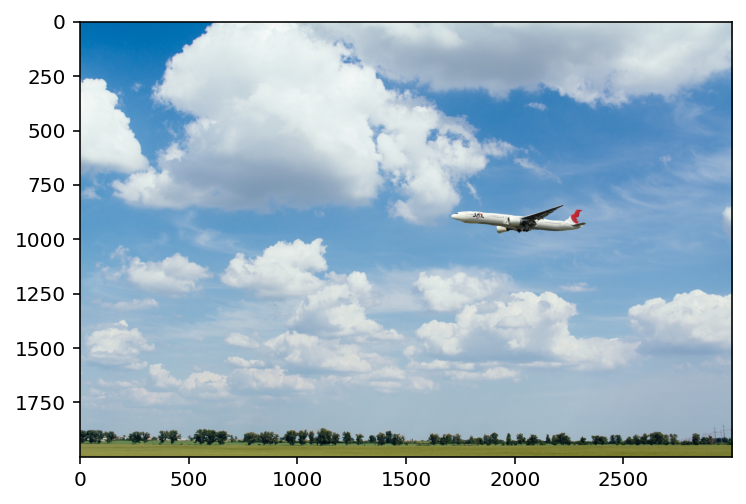

In [29]:
# Airplane
cropped_object, object_mask = align_source(orimg / 255, mask, background_img, bottom_center)

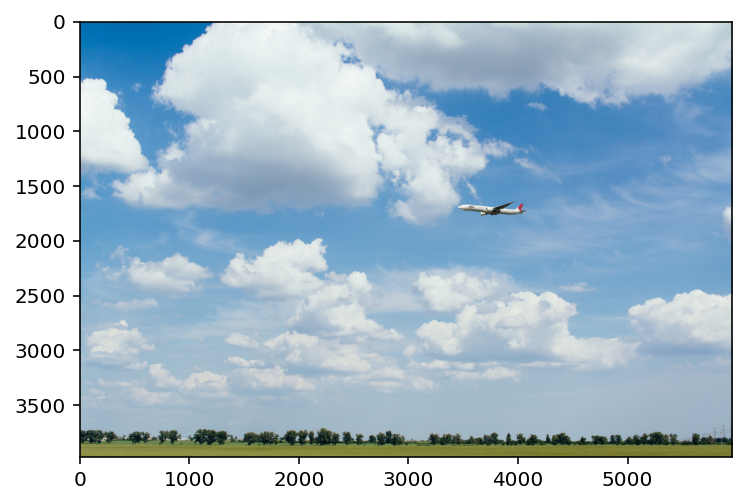

In [28]:
# Bottle
cropped_object, object_mask = align_source(orimg / 255, mask, background_img, bottom_center)

In [30]:
import scipy
from scipy.sparse.linalg import spsolve

In [31]:
from blending_func.poisson_blend import poisson_blend

In [38]:
def gradient_sum(img, i, j, h, w):
    v_sum = np.array([0.0, 0.0, 0.0])
    v_sum = img[i, j] * 4 \
        - img[i + 1, j] - img[i - 1, j] - img[i, j + 1] - img[i, j - 1]
    return v_sum

In [39]:
def poisson_blend(cropped_object, object_mask, background_img, bc):
    """
    :param cropped_object: numpy.ndarray One you get from align_cropped_object
    :param object_object_mask: numpy.ndarray One you get from align_cropped_object
    :param background_img: numpy.ndarray 
    """
    mask_height, mask_width = object_mask.shape
    region_size = mask_height * mask_width
    getk = lambda i, j: i + j * mask_height
    grad_func = lambda ii, jj: gradient_sum(cropped_object, ii, jj, mask_height, mask_width) # Gradient function
    b = np.zeros((region_size, 3)) # the "b" matrix
    A = scipy.sparse.identity(region_size, format='lil') # the "A" matrix
    for i in range(mask_height):
        for j in range(mask_width):
            k = getk(i, j)
            if object_mask[i, j] == 1: # We only need to do it in the blending region
                b_s = np.array([0.0, 0.0, 0.0])
                if object_mask[i - 1, j] == 1:
                    A[k, k - 1] = -1
                else:
                    b_s += background_img[i - 1, j]
                if object_mask[i + 1, j] == 1:
                    A[k, k + 1] = -1
                else:
                     b_s += background_img[i + 1, j]
                if object_mask[i, j - 1] == 1:
                    A[k, k - mask_height] = -1
                else:
                     b_s += background_img[i, j - 1]
                if object_mask[i, j + 1] == 1:
                    A[k, k + mask_height] = -1
                else:
                    b_s += background_img[i, j + 1] 
                A[k, k] = 4
                b[k] = grad_func(i, j) + b_s
            else:
                b[k] = background_img[i, j]
    A = A.tocsr()
    output = np.empty_like(background_img)
    output[:] = background_img
    for c in range(3):
        x = spsolve(A, b[:, c]) # Solving the equations
        x[x > 1] = 1
        x[x < 0] = 0
        x = x.reshape(mask_height, mask_width, order='F')
        output[:, :, c] = x
    return output # Our blended image

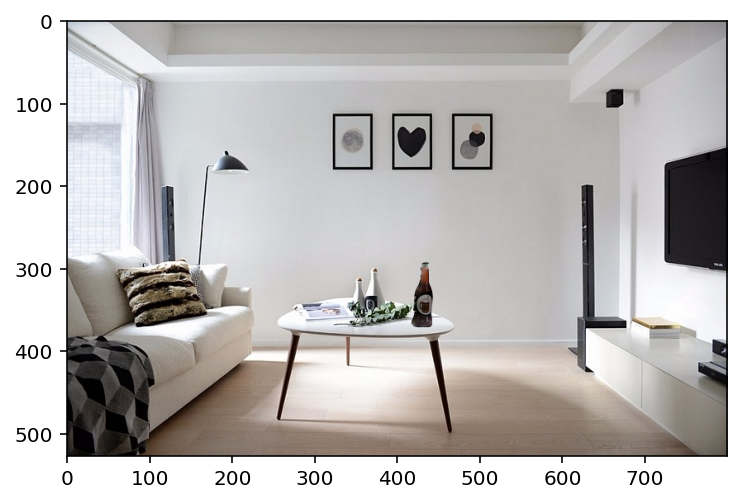

In [112]:
# Result bottle in room
im_blend = poisson_blend(cropped_object, object_mask, background_img, bottom_center)
if im_blend.any():
    %matplotlib inline
    plt.imshow(im_blend)

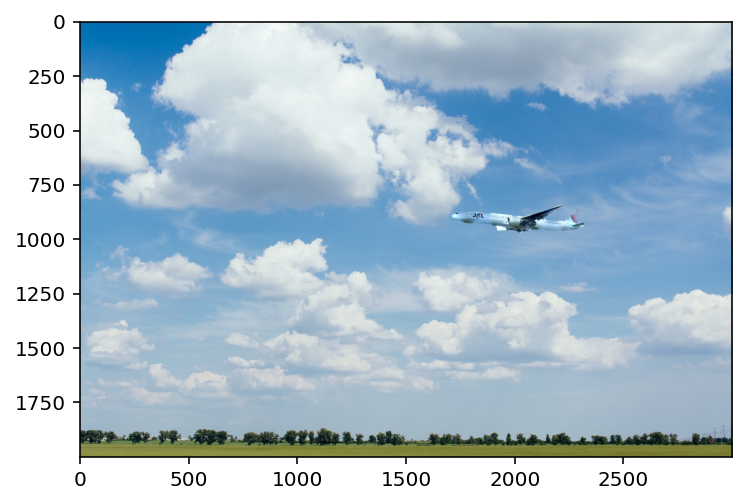

In [32]:
# Result airplane in sky
im_blend = poisson_blend(cropped_object, object_mask, background_img, bottom_center)
if im_blend.any():
    %matplotlib inline
    plt.imshow(im_blend)

In [113]:
plt.imsave("bottle-in-room.jpg", im_blend)

In [33]:
plt.imsave("plane-in-sky.jpg", im_blend)